In [1]:
# Standard libraries
from itertools import chain

# Parallelization library
from joblib import Parallel, delayed

# Scientific libraries
import pandas as pd
from numpy import array, arange
import matplotlib.pyplot as plt
import igraph as ig
import leidenalg as la

# Utility functions
from helpers.helpers_pandas import jenks_filter

Load the data

In [2]:
# Load the data
df = pd.read_pickle('../Data/pkl/01_spotify_data_(notna).pkl')
enao_df = pd.read_pickle('../Data/pkl/02_everynoise_data.pkl')[['genre', 'sim_genres', 'sim_weights', 'x', 'y', 'color']]

# Genres community detection

3 strategies are possible:
- Option 1: Use the "edges" naturally contained in our spotify Data (i.e. when one song "belongs" to 2 genres, those 2 genres are connected) 
- Option 2: Use the edges from EveryNoise website (i.e. if a genre si similar to another one, they share an edges)
- Option 3: Use a mix of both

I'm going for option 2 (the option 3 adds the challenge to justify the "combination" of each (average? Weighted average?)

In [3]:
# list all genres associated with a track
df_track_genres = df[['spotify_id', 'genres']].explode('genres')
df_track_genres

,spotify_id,genres
0,5ednSyvcdFQuDDBVVBT4dH,electro swing
0,5ednSyvcdFQuDDBVVBT4dH,nu jazz
1,7wjiAH7lWu5Vz8RuuZJ3Wo,hip-hop experimental
2,2vZTcQlxDaJ4N0wJycqzIZ,collage pop
2,2vZTcQlxDaJ4N0wJycqzIZ,new french touch
...,...,...
1913,6Vhtb9RU1thtzBcsy3bI9q,kirtan
1913,6Vhtb9RU1thtzBcsy3bI9q,world fusion
1914,03FcCV2h88qkjuhTaEB5Zh,high vibe
1914,03FcCV2h88qkjuhTaEB5Zh,kirtan


In [4]:
# list all tracks associated with each genre
df_tracks_per_genre = df[['spotify_id', 'genres']].explode('genres').groupby('genres').agg(list)
df_tracks_per_genre

,spotify_id
genres,
21st century classical,[0gByie4ptADcvfEEdFAFjB]
abstract,[03xyBEUCBBWZejQvDPXE94]
abstract beats,[2MYPFXScWdR3PQihBQxu7x]
abstract idm,[3wAGMTVMUdhEx22mLdJZNf]
acid techno,[0l1Whx4RQ6p8Nv3zIcb5Kq]
...,...
zenonesque,[6vBhadlx5nakGCwDENfCPw]
zilizopendwa,"[17bKimjkfYmDvHU2getgpZ, 4pMpXLVmlSbIjhZ552S2S..."
zim urban groove,"[4pMpXLVmlSbIjhZ552S2Sl, 0EB6LdcMyj0SHhCAR45CRi]"


To Use option 3, we can use this code snippet

In [5]:
# # Get the edges list contained in our Spotify Data
# # 2 tracks are connected if they share a same genre
# # the more common genres 2 tracks share, the more the weight

# sp_source = df_track_genres['spotify_id'].rename('source')
# sp_target = df_track_genres['genres'].map(df_tracks_per_genre['spotify_id']).rename('target')
# sp_edges = pd.concat([sp_source, sp_target], axis=1).explode('target').reset_index(drop=True)
# sp_edges['weight'] = 1 
# sp_edges

## Get edges list contained in ENAO data

In [6]:
# Normalize weight of ENAO data
# edge weight is divided by the sum of the edges'weight of the source node
enao_df['norm_weights'] = (enao_df['sim_weights'].apply(array)) / (enao_df['sim_weights'].apply(sum))
enao_df.drop(columns=['sim_weights'], inplace=True)
enao_df

,genre,sim_genres,x,y,color,norm_weights
0,musique peule,"[traditional soul, malian blues, world, musiqu...",950.0,8464.0,"[0.5647058823529412, 0.5254901960784314, 0.141...","[0.04500891265597148, 0.04500891265597148, 0.0..."
1,basel indie,"[stuttgart indie, fort worth indie, indie rock...",484.0,13405.0,"[0.6549019607843137, 0.4980392156862745, 0.243...","[0.04730983302411874, 0.04777365491651206, 0.0..."
2,west african jazz,"[oberkrainer, telugu devotional, folklore para...",948.0,8129.0,"[0.6392156862745098, 0.5372549019607843, 0.156...","[0.043898156277436345, 0.043898156277436345, 0..."
3,puglia indie,"[baltic post-punk, indietronica, uae indie, ch...",624.0,15558.0,"[0.6509803921568628, 0.5333333333333333, 0.298...","[0.049554013875123884, 0.049554013875123884, 0..."
4,slack-key guitar,"[hammered dulcimer, hawaiian, gamelan, string ...",803.0,5133.0,"[0.3215686274509804, 0.6588235294117647, 0.470...","[0.12023809523809524, 0.14642857142857144, 0.1..."
...,...,...,...,...,...,...
925,avant-garde jazz,"[straight-ahead jazz, jazz, free jazz, classic...",760.0,3710.0,"[0.32941176470588235, 0.5607843137254902, 0.39...","[0.029006318207926478, 0.034175761056863874, 0..."
926,rain,"[shush, sound, environmental, sleep, water]",64.0,5199.0,"[0.6509803921568628, 0.0, 0.7333333333333333]","[0.19626168224299065, 0.21495327102803738, 0.2..."
927,flamenco guitar,"[french jazz, gong, jazz catala, nuevo flamenc...",946.0,3996.0,"[0.4549019607843137, 0.5686274509803921, 0.682...","[0.1287001287001287, 0.12998712998713, 0.12870..."
928,south sudanese pop,"[reunion pop, african reggae, ugandan pop, hip...",1091.0,15406.0,"[0.6784313725490196, 0.5529411764705883, 0.054...","[0.04980276134122288, 0.04980276134122288, 0.0..."


In [7]:
# Get the edges list derived from the ENAO Data
# 2 tracks are connected if they share a similar genre
# the weight depends on how similar the genre the tracks share are

enao_source = df_track_genres['spotify_id'].rename('source')
# get similar genres for each genre associated to a track
enao_target = df_track_genres['genres'].map(enao_df.set_index(['genre'])['sim_genres']).rename('target')
# get normalized (similar) weight for each genre associated to a track
enao_weight = df_track_genres['genres'].map(enao_df.set_index(['genre'])['norm_weights']).rename('weight')
# combine the source (tracks) + similar genres + weight
enao_edges = pd.concat([enao_source, enao_target, enao_weight], axis=1).set_index('source').apply(pd.Series.explode).reset_index()
# replace similar genres with all tracks associated to that genre
enao_edges['target'] = enao_edges['target'].map(df_tracks_per_genre['spotify_id'])
# drop NAN in case some similar genres were not present in our spotify data
enao_edges = enao_edges.dropna().explode('target')
enao_edges

,source,target,weight
1,5ednSyvcdFQuDDBVVBT4dH,4yC8eJNtncmDmzoHsYVM3t,0.049125
1,5ednSyvcdFQuDDBVVBT4dH,5DC4xYFzlIsBkH4XiQXBB9,0.049125
1,5ednSyvcdFQuDDBVVBT4dH,4Ah8BSJEmhr0HJF5MbLpYp,0.049125
1,5ednSyvcdFQuDDBVVBT4dH,45DsH1EyXVLXOW3fwiAG1X,0.049125
1,5ednSyvcdFQuDDBVVBT4dH,3Opbxo0HMmn9JT8mljEGFH,0.049125
...,...,...,...
187847,03FcCV2h88qkjuhTaEB5Zh,6Vhtb9RU1thtzBcsy3bI9q,0.041877
187852,03FcCV2h88qkjuhTaEB5Zh,3WRWmHHisbBRFQnYeGOxeh,0.03955
187853,03FcCV2h88qkjuhTaEB5Zh,2gEZhXXPAa1PnAz3BouoAi,0.044203
187853,03FcCV2h88qkjuhTaEB5Zh,34w5is3aIx0z3UZQoJHmVz,0.044203


In our case, since we use Option 2

In [8]:
edges = enao_edges
# # sum duplicates edges (only in one direction)
# edges = edges.groupby(['source', 'target']).sum().reset_index()
# # remove loops (nodes connected to themselves)
# edges = edges[edges['source'] != edges['target']]
# # normalize weight (and round to integer)
# edges['weight'] = (edges['weight']/edges['weight'].min()).astype(int)
# # Reorder and reset index
# edges = edges.sort_values('weight', ascending=False).reset_index(drop=True)
edges

,source,target,weight
1,5ednSyvcdFQuDDBVVBT4dH,4yC8eJNtncmDmzoHsYVM3t,0.049125
1,5ednSyvcdFQuDDBVVBT4dH,5DC4xYFzlIsBkH4XiQXBB9,0.049125
1,5ednSyvcdFQuDDBVVBT4dH,4Ah8BSJEmhr0HJF5MbLpYp,0.049125
1,5ednSyvcdFQuDDBVVBT4dH,45DsH1EyXVLXOW3fwiAG1X,0.049125
1,5ednSyvcdFQuDDBVVBT4dH,3Opbxo0HMmn9JT8mljEGFH,0.049125
...,...,...,...
187847,03FcCV2h88qkjuhTaEB5Zh,6Vhtb9RU1thtzBcsy3bI9q,0.041877
187852,03FcCV2h88qkjuhTaEB5Zh,3WRWmHHisbBRFQnYeGOxeh,0.03955
187853,03FcCV2h88qkjuhTaEB5Zh,2gEZhXXPAa1PnAz3BouoAi,0.044203
187853,03FcCV2h88qkjuhTaEB5Zh,34w5is3aIx0z3UZQoJHmVz,0.044203


If we wanted to use Option 3, we would use the following step

In [9]:
# combine Spotify and ENAO-derived edges
# edges = pd.concat([sp_edges, enao_edges])
# # sum duplicates edges (only in one direction)
# edges = edges.groupby(['source', 'target']).sum().reset_index()
# # remove loops (nodes connected to themselves)
# edges = edges[edges['source'] != edges['target']]
# # normalize weight (and round to integer)
# edges['weight'] = (edges['weight']/edges['weight'].min()).astype(int)
# # Reorder and reset index
# edges = edges.sort_values('weight', ascending=False).reset_index(drop=True)
# edges

In [10]:
# Convert to iGraph
G = ig.Graph.DataFrame(edges, directed=False)
G.simplify(combine_edges='sum')  # both direction

In [11]:
# Convert back the edges list after simplification in DataFrame
# (Not necessary, only by curiosity)
G_edges = G.get_edge_dataframe()
G_nodes = G.get_vertex_dataframe()
G_edges['source'].replace(G_nodes['name'], inplace=True)
G_edges['target'].replace(G_nodes['name'], inplace=True)
# G_edges['weight'] = (G_edges['weight'] / G_edges['weight'].min()).astype(int)
G_edges.sort_values('weight', ascending=False, inplace=True)
G_edges

,source,target,weight
edge ID,,,
80277,0fzHYp3K1F1JKyQJM3Xy21,2p2kH4FCxWy0OSkaIuz7an,9.480938
258082,2p2kH4FCxWy0OSkaIuz7an,66QT68qxiBNyA7b95ur5Bm,7.604963
80336,0fzHYp3K1F1JKyQJM3Xy21,66QT68qxiBNyA7b95ur5Bm,7.604963
80249,0fzHYp3K1F1JKyQJM3Xy21,1Sp1eXSBaR4thIAXbWbyoA,7.485500
147585,1Sp1eXSBaR4thIAXbWbyoA,2p2kH4FCxWy0OSkaIuz7an,7.485500
...,...,...,...
344641,4GjD4v87Cv5WI7tsg5HLbZ,7ueP5u2qkdZbIPN2YA6LR0,0.020327
175453,1lz4RkL4oK07X0UAMEbqQT,72fuu9qDb0xXCH9vIaeJGa,0.018081
167961,1iUpKFWs8Uskzc1VXhLdLk,7ueP5u2qkdZbIPN2YA6LR0,0.016722


Weights ranges from 0.016722408026755852 to 9.480938342335236


<AxesSubplot:title={'center':'Weight distribution'}>

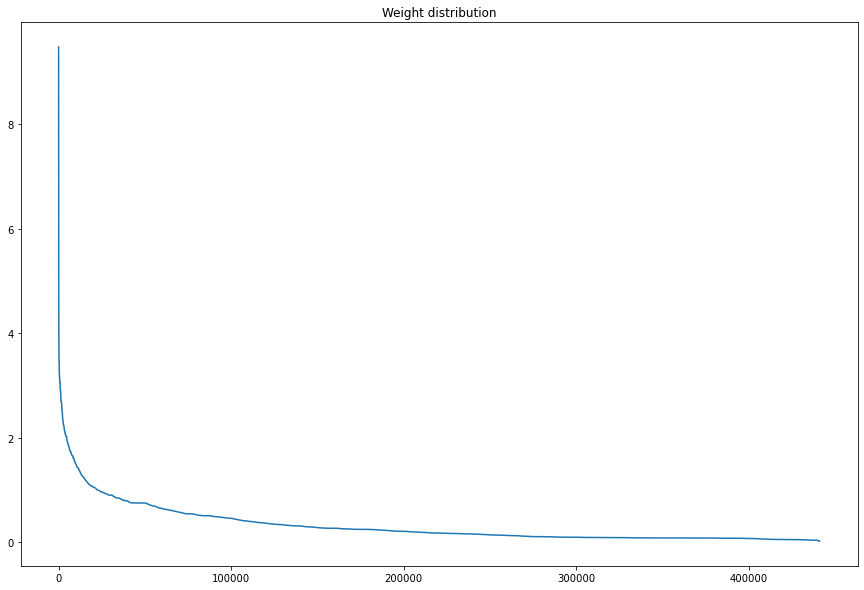

In [12]:
print(f"Weights ranges from {G_edges['weight'].min()} to {G_edges['weight'].max()}")
G_edges['weight'].sort_values(ascending=False).reset_index(drop=True).plot(figsize=(15,10), title='Weight distribution')

## Detect communities

In [13]:
def get_partition(graph, weight=None, seed=0):
    """Detect in communities in the graph using Leiden Algorithm.

    Args:
        graph (_type_): _description_
        weight (_type_, optional): _description_. Defaults to None.
        seed (int, optional): _description_. Defaults to 0.

    Returns:
        _type_: _description_
    """
    return la.find_partition(graph,
                                la.ModularityVertexPartition, 
                                n_iterations = -1, 
                                weights = weight, 
                                seed = seed
                            )


def partition_param(graph, weight, seed):
    """_summary_

    Args:
        graph (_type_): _description_
        weight (_type_): _description_
        seed (_type_): _description_

    Returns:
        _type_: _description_
    """
    modularity = get_partition(graph=graph, weight=weight, seed=seed).modularity
    return (seed, modularity)


def communities(graph, weight, seeds=10):
    """Get best communities (based on modularity) out of N tries 

    Args:
        graph (_type_): _description_
        weight (_type_): _description_
        seeds (int, optional): _description_. Defaults to 10.

    Returns:
        _type_: _description_
    """
    # Select the best result given the modularity
    results = Parallel(n_jobs=-1)(
        delayed(partition_param)(graph=graph, weight=weight, seed=seed)
        for seed in range(seeds)
    )
    best_seed, best_mod = max(results, key=lambda item: item[1])
    # Get the partition associated with the best seed
    partition = get_partition(graph=graph, weight=weight, seed=best_seed)
    clusters = dict()
    map = dict()
    for (i, x) in enumerate(partition):
        clusters[i] = graph.vs[x]["name"]
        map.update({genre: i for genre in graph.vs[x]["name"]})

    return {
        "map": map,              # keys = genres and values = clusters associated
        "seed": best_seed,       # seed associated with the best partition found
        "clusters": clusters,    # keys = cluster, values = all genres associated
        "modularity": best_mod,  # modularity for the best partition found
        "size": len(partition),  # number of clusters
        "partition": partition,  # the actual partition
    }

In [14]:
result = communities(graph=G, weight='weight', seeds=200)
print(f"The partitions includes {result['size']} clusters")
print(f"The modularity of the partition found by the Leiden Algorithm is: {result['modularity']}")

The partitions includes 8 clusters
The modularity of the partition found by the Leiden Algorithm is: 0.3475412981193308


In [15]:
result['clusters']

{0: ['017gRJ8IE2WZHWkt3S3XFo',
  '01VipW9SxHjH3HOyv7d7Do',
  '01oZjrRICAL5l0sSFqpb5D',
  '02Z8CtGDrjEIS3IQ5XEh1s',
  '03ldgz3uqDHzjhpVJicPRF',
  '03xyBEUCBBWZejQvDPXE94',
  '04jqhpf3oV06HtlmthfcZZ',
  '05vROgvHypXBp5ovciYJ0s',
  '06vVoluhGXvl5IygVV6dgG',
  '07Vp8mqbrIFtj7YgPMnoCE',
  '08igjK6cuk6VFcthQVgNzO',
  '09KSKjuieY3ekdNN2H1jrC',
  '09VRxuOUbMMJPwN258LBZ9',
  '0CJgpdxKejhopHEWf7hjQV',
  '0DPenz1hSSH4O8PXyEaggl',
  '0DQeHG1cTnvO49JNIYPfIB',
  '0DYYAOFnEbZ9NI95Oj8MmQ',
  '0Ddpe8znDaOuERlgLhJLWX',
  '0EP2GBgzae1XcAdAa7hbvj',
  '0F4XncIloN0ajjql23wSVi',
  '0Fp3TSyvGSR7hhlwtVZnp5',
  '0FzxpBbzXCiOjNvSW0Q1NY',
  '0HZtVLVL6oLU9WobKQxqGu',
  '0HdHd5mJlqFqv8PqAGDsEw',
  '0IVlx6wUnkGmU8zWXznnf1',
  '0J3BNRNxMxiLyWvG9hn3t6',
  '0KoVTMiYqzRyIrUKJVaXMO',
  '0O30XWFz799XGTyG6B8oSn',
  '0PC5KYZpygPcpeq063k4Kj',
  '0ReNWAidCpuubhPxTh5Q25',
  '0SQbJRNn2sC0QBXASVM5Op',
  '0ST9qkS1FIziDS5nQZqsMs',
  '0Snfykh4GFKKUVx2ozToYK',
  '0Tzdno0MqJtkCVOHjuIWna',
  '0U6SnCizI8cbrHLBOPO1kX',
  '0VRPdry6t4dZyH

## Assign each track to its cluster

In [16]:
df['cluster'] = df['spotify_id'].map(result['map'])
df = df.sort_values(['cluster', 'popularity'], axis=0, ascending=[True, False]).reset_index(drop=True)
df[['title', 'artists', 'genres', 'cluster','popularity']]

,title,artists,genres,cluster,popularity
0,Sail,[AWOLNATION],"[la indie, modern alternative rock, modern roc...",0.0,80
1,Eternal Youth,[RŮDE],"[japanese chillhop, rochester mn indie]",0.0,77
2,Intro,[The xx],"[downtempo, dream pop, indietronica]",0.0,77
3,Seve - Radio Edit,[Tez Cadey],"[deep tropical house, new french touch, tropic...",0.0,74
4,Glory Box,[Portishead],"[dark pop, electronica, laboratorio, trip hop]",0.0,74
...,...,...,...,...,...
1904,Bloom,[Sounds of Isha],[sound],6.0,42
1905,The Deepest Dream (Theta Waves),[Naturalis],"[rain, sound]",6.0,37
1906,Karibu - Radio Edit,[Lago],"[blackened hardcore, neo-crust]",7.0,0
1907,A New Beginning (Theta Drone L216Hz R220Hz),[Bruce Brus],[white noise],NaN,28


In [17]:
# Mind the track that do not belong to any cluster (they were singletons in our spotify data)
mask = df['cluster'].isna()
df[mask]

,spotify_id,title,artists,artists_id,genres,popularity,energy,valence,danceability,acousticness,loudness,speechiness,instrumentalness,liveness,tempo,key,mode,time_signature,duration_ms,cluster
1907,28lJQPHPOfJt9th5LciIbT,A New Beginning (Theta Drone L216Hz R220Hz),[Bruce Brus],[6jKgLzBdINpIrcinbmi7hI],[white noise],28,0.199,0.0367,0.397,0.873,-20.224,0.0412,0.746,0.1250,120.016,7,1,4,277612,NaN
1908,14nCED1JeR7yUvtKOVzrw6,Song for My Father,[Cedric IM Brooks & The Light of Saba],[697YONfQhe3i1GqsGVJIgn],[nyahbinghi],20,0.692,0.8010,0.647,0.076,-9.050,0.0582,0.817,0.0649,98.976,5,1,4,304813,NaN


In [18]:
# For the tracks that did not belong to any cluster, we define them as their own clusters 

unclustered = mask.sum()
if unclustered != 0:
    n = len(df['cluster'].unique()) - 1
    df.loc[mask,'cluster']  = arange(n, n+mask.sum(), 1)
    print(f"{mask.sum()} tracks did not belong to any clusters. They are now their own clusters (i.e. singletons)")

df['cluster'] = df['cluster'].astype(int)  # now they we have no missing data, we can convert to integers
df[mask]

2 tracks did not belong to any clusters. They are now their own clusters (i.e. singletons)


,spotify_id,title,artists,artists_id,genres,popularity,energy,valence,danceability,acousticness,loudness,speechiness,instrumentalness,liveness,tempo,key,mode,time_signature,duration_ms,cluster
1907,28lJQPHPOfJt9th5LciIbT,A New Beginning (Theta Drone L216Hz R220Hz),[Bruce Brus],[6jKgLzBdINpIrcinbmi7hI],[white noise],28,0.199,0.0367,0.397,0.873,-20.224,0.0412,0.746,0.1250,120.016,7,1,4,277612,8
1908,14nCED1JeR7yUvtKOVzrw6,Song for My Father,[Cedric IM Brooks & The Light of Saba],[697YONfQhe3i1GqsGVJIgn],[nyahbinghi],20,0.692,0.8010,0.647,0.076,-9.050,0.0582,0.817,0.0649,98.976,5,1,4,304813,9


## Visualization

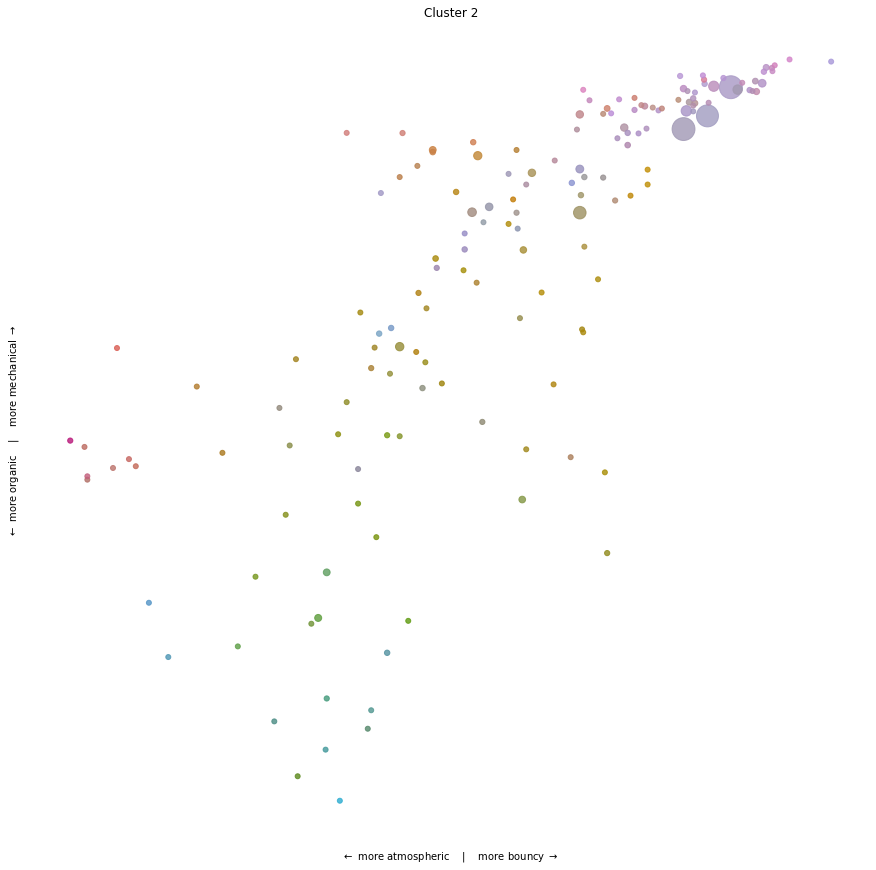

In [19]:
cluster = 2

%matplotlib inline

# Create the footprint
genres_in_cluster = df[df['cluster'] == cluster]["genres"].explode()
x = genres_in_cluster.map(enao_df.set_index('genre')['x']).rename('x')
y = genres_in_cluster.map(enao_df.set_index('genre')['y']).rename('y')
footprint = pd.concat([genres_in_cluster, x, y], axis=1).value_counts(ascending=False).rename('size').reset_index()
min_size, max_size = footprint['size'].min(), footprint['size'].max()
if min_size != max_size:
    footprint['size'] = (footprint['size'] - min_size) / (max_size - min_size)
else:
    footprint['size'] = (footprint['size'] - min_size) / min_size
footprint['color'] = footprint['genres'].map(enao_df.set_index('genre')['color'])

# Plot
ax = footprint.plot(x='x', y='y', 
                kind="scatter",
                figsize=(15,15), 
                title="Cluster " + str(cluster),
                s = footprint['size'].apply(lambda x: 500*x + 25),
                c = footprint['color'],
                alpha = 0.8,
            )
ax.set(xlabel=r"$\leftarrow$ more atmospheric    |    more bouncy $\rightarrow$",
        xticklabels=[],
        ylabel=r"$\leftarrow$ more organic    |    more mechanical $\rightarrow$",
        yticklabels=[],
    )
ax.spines[['top', 'bottom', 'right','left']].set_visible(False)
ax.tick_params(bottom=False, left=False)

plt.show()

In [20]:
nb_tracks = (df.groupby('cluster')['duration_ms'].count()).rename('nb tracks')
duraction = (df.groupby('cluster')['duration_ms'].sum()/3600000).round(1).rename('time (hours)')
clusters_overview = pd.concat([nb_tracks, duraction], axis=1)

tags = dict()

for cluster in df['cluster'].unique():
    mask = df['cluster'] == cluster
    all_genres = list(chain.from_iterable(df[mask]['genres'].to_list()))
    tags[cluster] = jenks_filter(all_genres, sort_by='count')

clusters_overview['main_genres'] = pd.Series(tags)
clusters_overview

,nb tracks,time (hours),main_genres
cluster,,,
0,612,48.1,"[electronica, downtempo, nu jazz, new french t..."
1,418,45.2,"[high vibe, shamanic, world fusion]"
2,378,40.0,"[organic house, organic electronic, ethnotroni..."
3,351,29.0,"[world, afropop, mande pop]"
4,106,7.5,"[chill beats, soundtrack, orchestral soundtrac..."
5,36,2.3,"[reggae, ska, rocksteady, roots reggae]"
6,5,0.5,[sound]
7,1,0.1,"[blackened hardcore, neo-crust]"
8,1,0.1,[white noise]


## Save the results

In [21]:
# Save all the data
df.to_pickle('../Data/pkl/03_spotify_data_clustered.pkl')
df.to_csv('../Data/csv/03_spotify_data_clustered.csv')  # For visualization